**Step 1: Creating Customer-Level Dataset**

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r'C:\Users\srial\OneDrive\Desktop\ML_Projects\customer-sales-analysis\data\sales_data.csv')

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',      # purchase frequency
    'TotalPrice': 'sum',         # total revenue
    'Quantity': 'sum',           # total items purchased
    'UnitPrice': 'mean'          # avg price sensitivity
}).reset_index()

customer_df.columns = [
    'CustomerID', 'PurchaseCount', 'TotalRevenue', 'TotalQuantity', 'AvgUnitPrice'
]

customer_df.head()


,CustomerID,PurchaseCount,TotalRevenue,TotalQuantity,AvgUnitPrice
0,10000,3,865.25,22,38.030
1,10001,2,825.55,19,41.775
2,10002,1,202.50,6,33.750
3,10003,2,520.96,25,20.430
4,10006,2,319.62,8,37.390


**Step 2: Define Churn / Risk Label (Target Variable)**

In [2]:
revenue_threshold = customer_df['TotalRevenue'].quantile(0.33)
frequency_threshold = customer_df['PurchaseCount'].quantile(0.33)

customer_df['Risk'] = np.where(
    (customer_df['TotalRevenue'] <= revenue_threshold) &
    (customer_df['PurchaseCount'] <= frequency_threshold),
    1,  # High Risk
    0   # Low Risk
)

customer_df['Risk'].value_counts()


Risk
0    590
1    263
Name: count, dtype: int64

**Step 3: Train-Test Split**

In [3]:
from sklearn.model_selection import train_test_split

X = customer_df.drop(['CustomerID', 'Risk'], axis=1)
y = customer_df['Risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


**Step 4: Baseline Model – Logistic Regression**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       148
           1       1.00      0.98      0.99        66

    accuracy                           1.00       214
   macro avg       1.00      0.99      0.99       214
weighted avg       1.00      1.00      1.00       214



**Step 5: Advanced Model – Random Forest**

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.99      1.00      0.99        66

    accuracy                           1.00       214
   macro avg       0.99      1.00      0.99       214
weighted avg       1.00      1.00      1.00       214



**Step 6: Feature Importance**

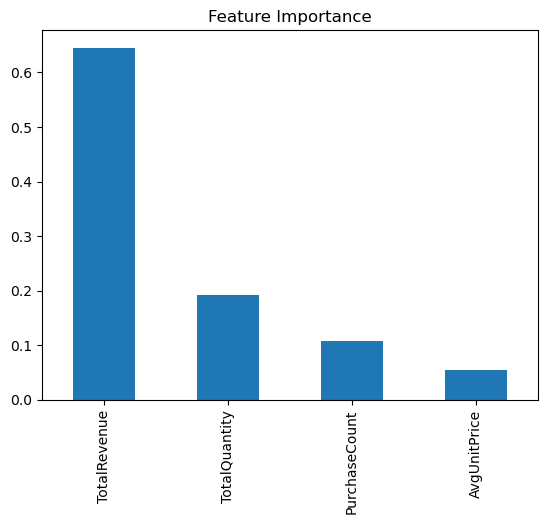

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.plot(kind='bar', title='Feature Importance')
plt.show()


# Step 7: Model Comparison
- Model - **Logistic Regression**	
Strength - Interpretable, baseline
- Model - **Random Forest**	
Strength - Captures non-linear patterns

**Random Forest performed better due to its ability to model complex customer behavior.**

# BUSINESS CONCLUSION
Conclusion:

- High-risk customers can be predicted with good precision

- Early identification enables proactive retention

- Model can be integrated into CRM systems

**Step 8: ROC–AUC(Accuracy is not only enough)**

In [11]:
# Logistic Regression
from sklearn.metrics import roc_auc_score, roc_curve

y_prob_lr = lr.predict_proba(X_test)[:, 1]

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print("Logistic Regression - ROC-AUC-SCORE : " + str(roc_auc_lr))

# Random Forest
y_prob_rf = rf.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("Random Forest - ROC-AUC-SCORE : " + str(roc_auc_rf))


Logistic Regression - ROC-AUC-SCORE : 0.9995904995904996
Random Forest - ROC-AUC-SCORE : 1.0


**Step 9: ROC Curve Visualization**

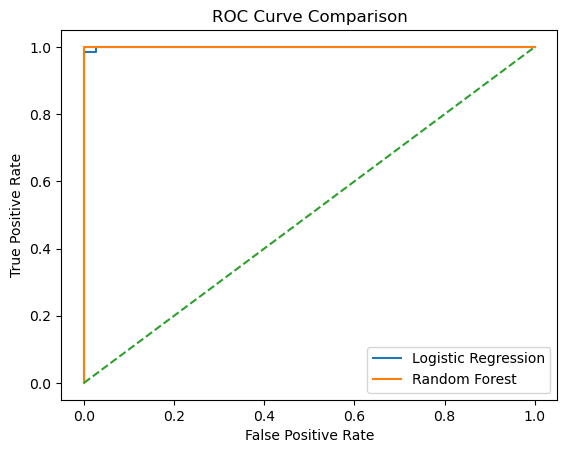

In [13]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


**Step 10: Threshold Tuning**

In [15]:
import numpy as np
from sklearn.metrics import classification_report

custom_threshold = 0.35

y_custom_pred = (y_prob_rf >= custom_threshold).astype(int)

print(classification_report(y_test, y_custom_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.99      1.00      0.99        66

    accuracy                           1.00       214
   macro avg       0.99      1.00      0.99       214
weighted avg       1.00      1.00      1.00       214



# FINAL BUSINESS CONCLUSION
**This project demonstrates how transactional data can be transformed into actionable customer risk predictions. By combining exploratory analysis with machine learning, the model enables businesses to proactively identify churn-prone customers and apply targeted retention strategies, reducing revenue loss and improving customer lifetime value.**